### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [1]:
%env CUDA_VISIBLE_DEVICES=3
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
sys.path.append("/home/shirobokov/.local/lib/python3.6/site-packages/")

env: CUDA_VISIBLE_DEVICES=3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [2]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [3]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [4]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA(
    (branch1x1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1,

In [5]:
import torch
from torch.autograd import Variable

dummy_x = Variable(torch.randn(5, 3, 299, 299))
model(dummy_x)

Variable containing:
-1.3912  0.9944  1.7704  ...  -1.7406 -0.4057  1.1924
-1.2794  1.1768  1.8767  ...  -1.8066 -0.3511  1.7607
-1.4425  0.8658  1.6389  ...  -1.4092 -0.1931  1.5771
-1.4701  0.9677  1.9940  ...  -1.7592 -0.5029  1.4445
-1.4769  1.0146  1.9102  ...  -1.9455 -0.2844  1.5487
[torch.FloatTensor of size 5x1000]

### Predict class probabilities

/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


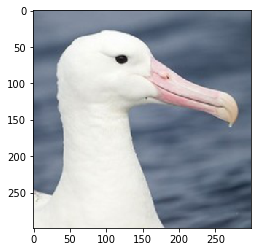

top-10 classes are: 
 [prob : class label]
0.9747 :	albatross
0.0026 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0004 :	collie
0.0003 :	hammerhead
0.0003 :	drake
0.0003 :	nipple
0.0003 :	Polaroid camera


In [6]:
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

img = imresize(plt.imread('sample_images/albatross.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



### Having fun with pre-trained nets

In [7]:
#!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


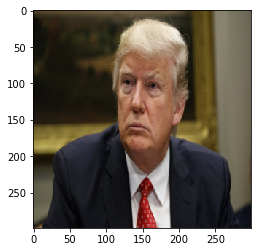

top-10 classes are: 
 [prob : class label]
0.7468 :	suit
0.0806 :	Windsor tie
0.0379 :	groom
0.0042 :	Loafer
0.0035 :	oboe
0.0030 :	academic gown
0.0022 :	wig
0.0020 :	bow tie
0.0019 :	Sussex spaniel


In [8]:
img = imresize(plt.imread('img.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [9]:
# !wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O /home/shirobokov/data/cat_vs_dogs.zip
# !unzip data.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [10]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()
embedding.cuda(0)

assert embedding(img.cuda(0)).data.cpu().numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [12]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imread, imresize
import numpy as np
import os

X = []
Y = []

batch_size = 2
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0
i =0 
for fname in tqdm(os.listdir('/home/shirobokov/data/cat_vs_dogs/train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("/home/shirobokov/data/cat_vs_dogs/train", fname))
    
    img = imresize(img, (299, 299)) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = Variable(torch.FloatTensor(imgs.transpose([0,3,1,2]))).cuda(0)
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor)
        
        X.append(features.data.cpu().numpy())
        batch_index = 0
        continue
    i +=1
    if i == 2000:
        break
    batch_index += 1

  0%|          | 0/25000 [00:00<?, ?it/s]/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):



RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/THCTensorCopy.cu:204

In [57]:
import numpy as np

X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

ValueError: need at least one array to concatenate

In [ ]:
<split data here or use cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
<YOUR CODE>

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [17]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [18]:
modulelist = list(model.children())

In [23]:
len(modulelist)

18

## need to adjust branching of inception to match size

In [51]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])

def dd_helper(image, layer, iterations, lr):        
    
    input_var = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            print(j)
            if j == 13:
                out = out.view(1, 1780224)
            out = modulelist[j](out)
            print(j, out.size())
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0,1)
    input_im.transpose_(1,2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [52]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

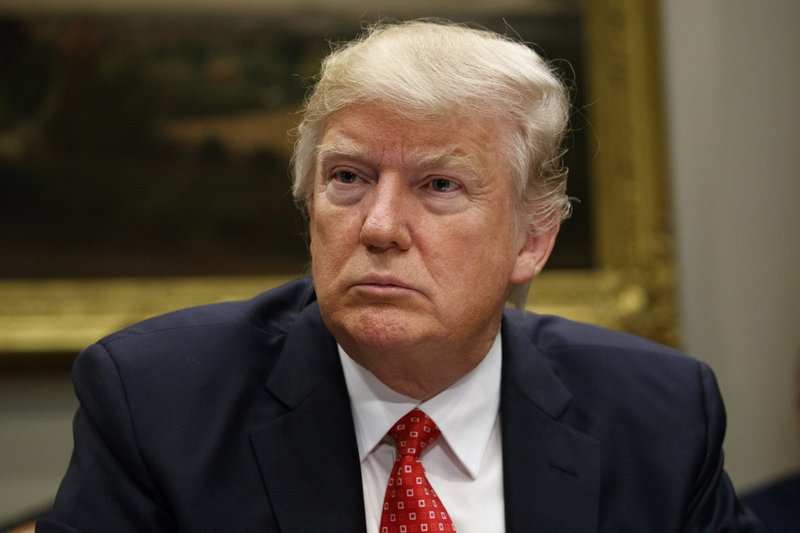

In [53]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [54]:
output = deep_dream_vgg(img, 15, 10, 0.3, 2, 0)

-------------- Recursive level:  0 --------------
0
0 torch.Size([1, 32, 266, 399])
1
1 torch.Size([1, 32, 264, 397])
2
2 torch.Size([1, 64, 264, 397])
3
3 torch.Size([1, 80, 264, 397])
4
4 torch.Size([1, 192, 262, 395])
5
5 torch.Size([1, 256, 262, 395])
6
6 torch.Size([1, 288, 262, 395])
7
7 torch.Size([1, 288, 262, 395])
8
8 torch.Size([1, 768, 130, 197])
9
9 torch.Size([1, 768, 130, 197])
10
10 torch.Size([1, 768, 130, 197])
11
11 torch.Size([1, 768, 130, 197])
12
12 torch.Size([1, 768, 130, 197])
13


RuntimeError: invalid argument 2: size '[1 x 1780224]' is invalid for input with 19668480 elements at /pytorch/torch/lib/TH/THStorage.c:41

In [ ]:
output = deep_dream_vgg(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>